Input File(s)

In [1]:
img1Path = "./pipelineInput/0X7AFF5B2DEEE839B9_35.png"
img2Path = "./pipelineInput/0X7AFF5B2DEEE839B9_47.png"

Center Model

In [2]:
import cv2
import numpy as np
import torch

#prepare input
def loadImage(imgPath):
    image = cv2.imread(imgPath, cv2.IMREAD_GRAYSCALE)  # ensure 1-channel
    if image is None:
        raise FileNotFoundError(f"Image not found: {imgPath}")

    image = image.astype('float32') / 255.0  # normalize manually if not using transforms
    image = np.expand_dims(image, axis=0)    # [1, 112, 112]
    image = np.expand_dims(image, axis=0)    # [1, 1, 112, 112], simulated dataloader
    image = torch.tensor(image, dtype=torch.float32)

    return image

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionNet(nn.Module):
    def __init__(self, image_size=112, patch_size=16, embed_dim=64, num_heads=4, depth=2):
        super().__init__()
        assert image_size % patch_size == 0, "Image size must be divisible by patch size"

        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        self.embed_dim = embed_dim

        self.patch_embed = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)

        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.head = nn.Sequential(
        nn.LayerNorm(embed_dim),
        nn.Linear(embed_dim, 2),
        )

    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)
        x = x + self.pos_embed

        x = self.transformer(x)
        x = x.mean(dim=1)

        out = self.head(x)
        return out

In [4]:
import torch
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionNet().to(device)

weightsPath = "./center_model.pth"
model.load_state_dict(torch.load(weightsPath, map_location=device))

img1 = loadImage(img1Path)
img2 = loadImage(img2Path)

with torch.no_grad():
    coord1 = model(img1.to(device))
    coord2 = model(img2.to(device))


MedSam

In [5]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from transformers import SamModel, SamProcessor
from torch import nn
import torch.optim as optim
from tqdm import tqdm

In [6]:
def load_checkpoint(model, optimizer, filepath, device):
    checkpoint = torch.load(filepath, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from {filepath}, epoch {epoch}, loss {loss:.4f}")
    return epoch, loss


In [7]:
model = SamModel.from_pretrained("wanglab/medsam-vit-base").to(device)
processor = SamProcessor.from_pretrained("wanglab/medsam-vit-base")
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)


load_checkpoint(model, optimizer, "./sam_ultrasound_checkpoints/best_model.pt", device)


Checkpoint loaded from ./sam_ultrasound_checkpoints/best_model.pt, epoch 5, loss 0.0256


(5, 0.02558339418563992)

In [10]:
# prep images and coordinates for medsam
def prepDataMEDSAM(imgPath, coords):
    image_size = 256
    image_transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor()
        ])
    
    img = Image.open(imgPath).convert("RGB")
    orig_w, orig_h = img.size
    img_tensor = image_transform(img)

    scaled_x = int(coords[0] * image_size)
    scaled_y = int(coords[1] * image_size)
    coords = [[scaled_x, scaled_y]]

    return img_tensor, coords

img1Tensor, coords1 = prepDataMEDSAM(img1Path, coord1.numpy().squeeze())
img2Tensor, coords2 = prepDataMEDSAM(img2Path, coord2.numpy().squeeze())


In [11]:
inputs = processor(
                images=[img1Tensor, img2Tensor],
                input_points=[coords1, coords2],
                return_tensors="pt",
                do_rescale=False,
                padding="longest"
            ).to(device)
            
with torch.no_grad():
    outputs = model(**inputs)

pred_masks = outputs.pred_masks.cpu()

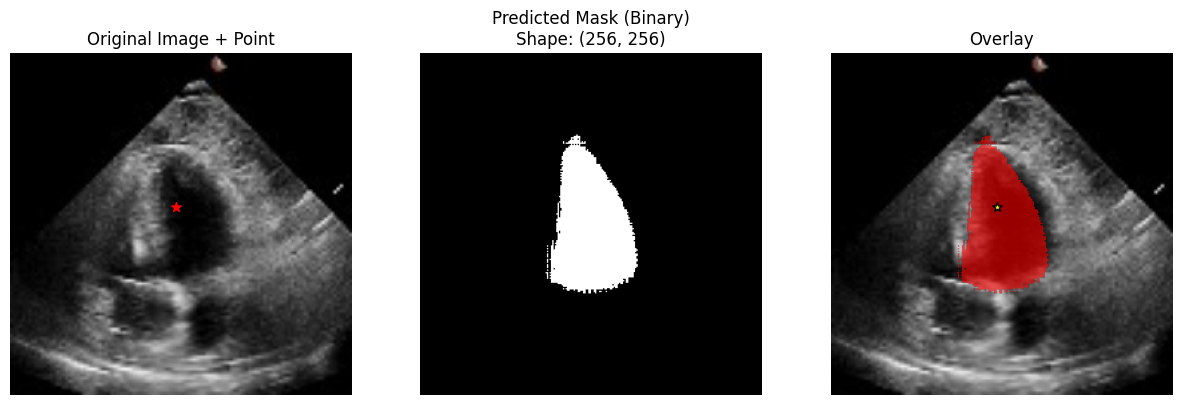

In [19]:
#visualize prediction
def visualizePreds(imgTensor, pred_mask, coords):
    image = imgTensor.permute(1, 2, 0).numpy()

    medsam_seg_prob = torch.sigmoid(pred_mask).numpy()
    
    if len(medsam_seg_prob.shape) == 3:
        mask_2d = medsam_seg_prob[0]
    else:
        mask_2d = medsam_seg_prob
    
    binary_mask = (mask_2d > 0.5).astype(np.float32)

    
    plt.figure(figsize=(15, 5))

    # input image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.scatter(coords[0][0], coords[0][1], c='red', s=50, marker='*')
    plt.title("Original Image + Point")
    plt.axis('off')

    # predicted mask
    plt.subplot(1, 3, 2)
    plt.imshow(binary_mask, cmap="gray")
    plt.title(f"Predicted Mask (Binary)\nShape: {binary_mask.shape}")
    plt.axis('off')
    
    # overlay
    plt.subplot(1, 3, 3)
    plt.imshow(image)
    colored_mask = np.zeros((*binary_mask.shape, 4))  # RGBA
    colored_mask[binary_mask > 0.5] = [1, 0, 0, 0.6]  # Red with alpha
    plt.imshow(colored_mask)
    plt.scatter(coords[0][0], coords[0][1], c='yellow', s=50, marker='*', edgecolors='black')
    plt.title("Overlay")
    plt.axis('off')


    plt.show()

visualizePreds(img1Tensor, pred_masks[0].squeeze(), coords1)